@article{ashtari2023factorizer,
  title     = {Factorizer: A scalable interpretable approach to context modeling for medical image segmentation},
  author    = {Ashtari, Pooya and Sima, Diana M and De Lathauwer, Lieven and Sappey-Marinier, Dominique and Maes, Frederik and Van Huffel, Sabine},
  journal   = {Medical image analysis},
  publisher = {Elsevier},
  year      = {2023},
  issn      = {1361-8415},
  doi       = {https://doi.org/10.1016/j.media.2022.102706},
  pages     = {102706},
  volume    = {84},

}

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
from torch.quantization import QuantStub, DeQuantStub
import factorizer as ft
from get_factorizer_dataset import get_dataloader
from tqdm import tqdm
import time
from IPython.display import clear_output

In [2]:
train, test = get_dataloader('contrast_blue_quantized_5', 'masks_2', 1)

In [3]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

In [4]:
swin_factorizer = ft.Factorizer(
    in_channels=3,
    out_channels=6,
    spatial_size=(576, 768),
    encoder_depth=(1, 1, 1, 1, ),
    encoder_width=(8, 16, 16, 24),
    strides=(1, 2, 2, 2, 2,2),
    decoder_depth=(1, 1, 1,),
    norm=ft.LayerNorm,
    reshape=(ft.SWMatricize, {'head_dim': 8, 'patch_size': 4}),
    act=nn.ReLU,
    factorize=ft.NMF,
    rank=1,
    num_iters=5,
    init="uniform",
    solver="mu",
    mlp_ratio=2,
    dropout=0.1,
    num_deep_supr=True
)

swin_factorizer = swin_factorizer.to(device)

In [5]:
with torch.no_grad():
    o = swin_factorizer(torch.randn((1,3,576,768)).to(device))
    for thing in o:
        print(thing.shape)

torch.Size([1, 6, 576, 768])
torch.Size([1, 6, 288, 384])
torch.Size([1, 6, 144, 192])


In [6]:
# color_mapping = torch.tensor([(0,0,0),(60, 28, 255),(73, 255, 52),(255, 70, 70),(7, 255, 251),(88, 88, 88)]) old mapping
color_mapping = torch.tensor([(0,0,0), (6,4,243), (88,255,52), (255,28,36), (77,241,232), (209,209,216)]) 
def assemble_image(segmented):
    '''
    Assemble segmented images from segmentation model's output

    Args:
        segmented (Pytorch tensor): (1,6,568,764) tensor that contains 6 binary masks, one for each class

    Returns:
        RGB image made of combined binary masks
    '''
    indices = torch.argmax(segmented, dim=1,keepdim=True)
    return color_mapping[indices][0][0]


In [7]:
def soft_dice_loss(y_pred, y_true, axis=(1, 2), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Pytorch tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim)
        y_pred (Pytorch tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    dice_numerator = 2. * torch.sum(y_true * y_pred, dim=axis) + epsilon
    dice_denominator = torch.sum(y_true**2, dim=axis) + torch.sum(y_pred**2, dim=axis) + epsilon
    dice_loss = 1 - torch.mean((dice_numerator)/(dice_denominator))


    ### END CODE HERE ###

    return dice_loss

In [8]:
with torch.no_grad():
    img, masks, mask = next(iter(train))
    print(masks.shape)
    # print(soft_dice_loss(masks[0][0], masks[0][0]))

torch.Size([1, 6, 576, 768])


In [9]:
dice = soft_dice_loss
CE = nn.CrossEntropyLoss()
pool = nn.MaxPool2d((2,2), 2)

def factorizer_loss(preds, mask):
    loss = 0
    loss_coeff = [1.0, 0.5, 0.25, 1/8, 1/16]
    i = 0
    for pred in preds:
        loss += loss_coeff[i] * (dice(pred, mask) + CE(pred, mask))
        mask = pool(mask)
        i += 1

    return loss

In [10]:
def train_factorizer(model, loader, criterion, optimizer, num_epochs=10, yscale=None):
    model.train()
    losses = []
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for batch in loader:
            images, masks, _ = batch
            segmented = model(images)
            loss = criterion(segmented, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach().item()
        losses.append(epoch_loss)
        clear_output(wait=True)
        plt.plot(losses)
        if (yscale == 'log'):
            plt.yscale('log')  # Logarithmic y-axis
            plt.title('Train Loss (Log Scale) over Epochs')
            plt.ylabel('Train Loss (log)')
        else:
            plt.title('Train Loss over Epochs')
            plt.ylabel('Train Loss')
        plt.xlabel('Epoch')
        
        plt.grid(True)
        plt.legend()
        plt.show()
                

In [11]:
param_size = 0
for param in swin_factorizer.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in swin_factorizer.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 0.706MB


In [12]:
optimizer = torch.optim.AdamW(swin_factorizer.parameters(), lr=1e-4, weight_decay=1e-2)

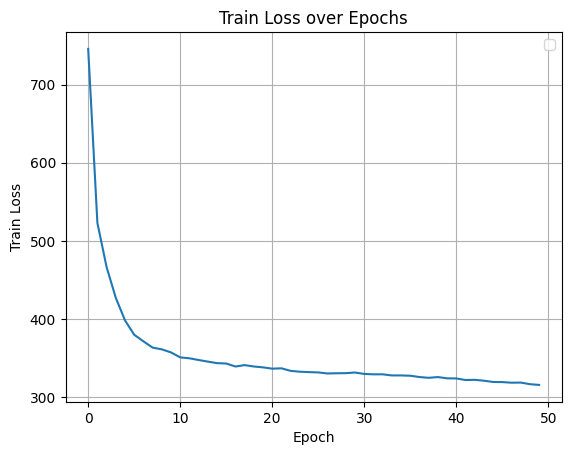

100%|██████████| 50/50 [1:10:42<00:00, 84.85s/it]


In [13]:
train_factorizer(swin_factorizer, train, factorizer_loss, optimizer, num_epochs=50)

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=[dice_coef(y_true[:,index,:,:], y_pred[:,index,:,:]) for index in range(numLabels)]
    return (dice, np.sum(dice)/numLabels)

def dice_score(y_true: torch.Tensor, y_pred: torch.Tensor):
    """ 
    Computes dice score between rgb masks 

    Args:
        y_true (Pytorch tensor): tensor of shape (batch, 3, height, width) or (batch, height, width, 3) containing ground truth
        y_pred (Pytorch tensor): tensor of shape (batch, 3, height, width) or (batch, height, width, 3) containing binary masks from model output

    Returns:
        dice_score (float array): array of length batch with dice_score[i] between 0 and 1 representing the dice score between y_true[i] and y_pred[i]
    """
    assert y_true.shape == y_pred.shape, f'Inputs shapes not equal. y_true.shape: {y_true.shape} | y_pred.shape: {y_pred.shape}'

    # if (batch, 3, height, width), then permute to (batch, height, width, 3) for easier for loop
    # function takes in (batch, 3, height, width) because it is a common format
    if y_true.shape[1] == 3:
        y_true = y_true.permute(0, 2, 3, 1)
    if y_pred.shape[1] == 3:
        y_pred = y_pred.permute(0, 2, 3, 1)
    dice_score = []
    for mask in range(y_true.shape[0]):
        overlap = (y_pred[mask] == y_true[mask]).all(dim=2).flatten().sum()
        total_area = y_true.shape[1] * y_true.shape[2] * 2
        dice_score.append((2 * overlap) / total_area)
    return dice_score

torch.Size([1, 6, 576, 768])
torch.Size([1, 3, 576, 768])
torch.Size([1, 3, 576, 768])
Assembled Image Dice Score: [tensor(0.5979, device='mps:0')]


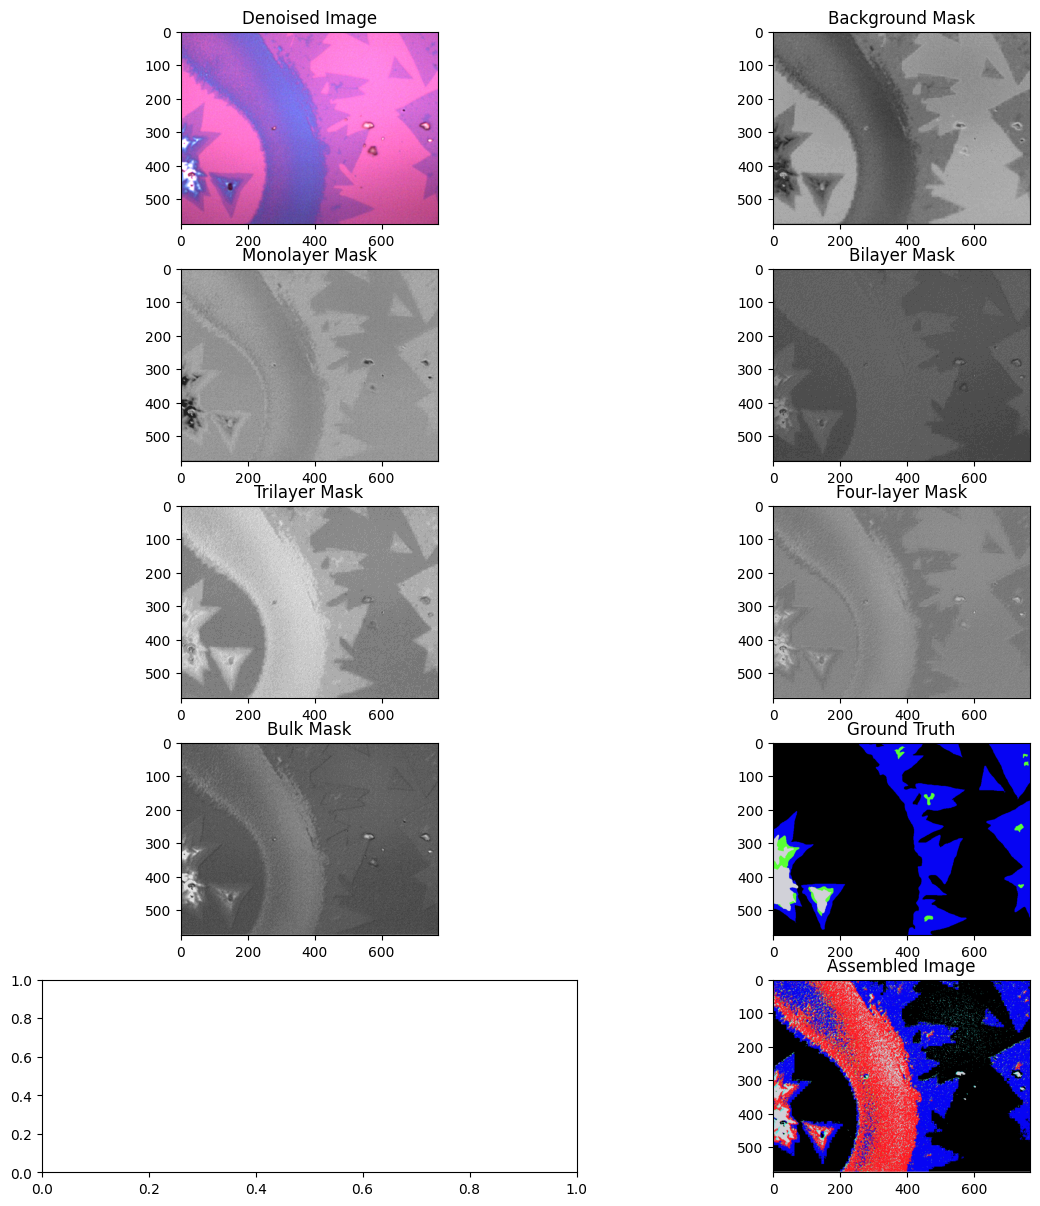

In [23]:
with torch.no_grad():
    img, masks, mask = next(iter(test))
    img = img.to(device)
    masks = masks.to(device)
    swin_factorizer.eval()
    output = swin_factorizer(img)
    soft = torch.nn.Softmax2d()
    output = torch.nn.functional.normalize(output[0], 1, dim=(2,3))
    output = soft(output)
    print(output.shape)
    
    output = output.detach().cpu().numpy()
    masks = masks.detach().cpu().numpy()
    fig, axs = plt.subplots(5, 2)
    fig.set_size_inches(12,12)
    fig.tight_layout()
    axs[0,0].set_title("Denoised Image")
    axs[0,0].imshow(img[0].detach().cpu().numpy().transpose(1,2,0) / 255.0)
    axs[0,1].set_title("Background Mask")
    # print(torch.histogram(torch.tensor(output[0][0]), bins=10))
    axs[0,1].imshow(output[0][0], cmap='gray')
    axs[1,0].set_title("Monolayer Mask")
    axs[1,0].imshow(output[0][1], cmap='gray')
    axs[1,1].set_title("Bilayer Mask")
    # print(torch.histogram(torch.tensor(output[0][2]), bins=10))
    axs[1,1].imshow(output[0][2], cmap='gray')
    axs[2,0].set_title("Trilayer Mask")
    axs[2,0].imshow(output[0][3], cmap='gray')
    axs[2,1].set_title("Four-layer Mask")
    axs[2,1].imshow(output[0][4], cmap='gray')
    axs[3,0].set_title("Bulk Mask")
    axs[3,0].imshow(output[0][5], cmap='gray')
    axs[3,1].set_title("Ground Truth")
    axs[3,1].imshow(mask[0].permute(1,2,0).detach().cpu().numpy()/255.0)
    # worst_mask = output[0][np.argmin(scores)]
    # corresponding_mask = masks[0][np.argmin(scores)]
    # axs[4,0].set_title("Worst Mask")
    # axs[4,0].imshow(worst_mask, cmap='gray')
    axs[4,1].set_title("Assembled Image")
    final_output = assemble_image(torch.tensor(output))
    axs[4,1].imshow(final_output)
    final_output = torch.unsqueeze(final_output.permute(2,0,1), 0).to(device)
    print(mask.shape)
    print(final_output.shape)
    print(f'Assembled Image Dice Score: {dice_score(mask, final_output)}')
    plt.show()